In [1]:
%config InlineBackend.figure_format='retina'

# Add the parent directory to the path so that we can import the modules.
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from market_conditions import *
from dynamic_contagion import *
from reinsurance import *

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Other parameters
maturity = 3
markup = 0.4
R = int(1e5)
seed = 123

# Asset parameters
V_0 = 130
phi_V = -3  # * (1.3) # = V0 / L0
sigma_V = 0.05

# Liability parameters
L_0 = 100
phi_L = -3
sigma_L = 0.02

# Interest rate parameters
r_0 = 0.02
kappa = 0.2
m = 0.05  # 0.5
upsilon = 0.1
lambda_r = -0.01

In [3]:
all_time_series = get_market_conditions(
    R=R,
    seed=seed,
    maturity=maturity,
    kappa=kappa,
    lambda_r=lambda_r,
    m=m,
    phi_V=phi_V,
    sigma_V=sigma_V,
    phi_L=phi_L,
    sigma_L=sigma_L,
    upsilon=upsilon,
    V_0=V_0,
    L_0=L_0,
    r_0=r_0,
)

V_T, L_T, int_r_t = summarise_market_conditions(all_time_series, maturity)

Loading 'c:\Users\Patrick\Dropbox\Jiwook Project Local\catastrophe-reinsurance-pricing-compound-point-process\data\mc-R=100000,seed=123,maturity=3,kappa=0.2,lambda_r=-0.01,m=0.05,phi_V=-3,sigma_V=0.05,phi_L=-3,sigma_L=0.02,upsilon=0.1,V_0=130,L_0=100,r_0=0.02.npy'


100%|██████████| 100000/100000 [00:00<00:00, 215559.67it/s]


In [4]:
assert np.isnan(all_time_series).mean() == 0

In [5]:
# Poisson process
def simulate_poisson(rg):
    lambda_ = 0.5
    return rg.poisson(lambda_ * maturity)


# Cox proces
def simulate_cox(rg):
    lambda0 = 0.49
    a = 0.4
    rho = 0.4
    delta = 1

    selfJumpSizeDist = lambda rg: 0
    extJumpSizeDist = lambda rg: rg.uniform(0, 0.5)

    return simulate_num_dynamic_contagion(
        rg, maturity, lambda0, a, rho, delta, selfJumpSizeDist, extJumpSizeDist
    )


# Hawkes process
def simulate_hawkes(rg):
    lambda0 = 0.47
    a = 0.26
    rho = 0.4
    delta = 1

    selfJumpSizeDist = lambda rg: rg.uniform()
    extJumpSizeDist = lambda rg: 0

    return simulate_num_dynamic_contagion(
        rg, maturity, lambda0, a, rho, delta, selfJumpSizeDist, extJumpSizeDist
    )


# Dynamic contagion process
def simulate_dcp(rg):
    lambda0 = 0.29
    a = 0.26
    rho = 0.4
    delta = 1

    selfJumpSizeDist = lambda rg: rg.uniform()
    extJumpSizeDist = lambda rg: rg.uniform(0, 0.5)

    return simulate_num_dynamic_contagion(
        rg, maturity, lambda0, a, rho, delta, selfJumpSizeDist, extJumpSizeDist
    )

In [6]:
# Catastrophe loss size distribution parameters
mu_C = 2
sigma_C = 0.5

seed = 123
rg = rnd.default_rng(seed)

C_T_poisson, num_cats_poisson = simulate_catastrophe_losses(
    rg, R, simulate_poisson, mu_C, sigma_C
)

C_T_cox, num_cats_cox = simulate_catastrophe_losses(rg, R, simulate_cox, mu_C, sigma_C)

C_T_hawkes, num_cats_hawkes = simulate_catastrophe_losses(
    rg, R, simulate_hawkes, mu_C, sigma_C
)

C_T_dcp, num_cats_dcp = simulate_catastrophe_losses(rg, R, simulate_dcp, mu_C, sigma_C)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [7]:
print(
    f"Average number of catastrophes from Poisson process: {np.mean(num_cats_poisson):.2f}"
)
print(f"Average number of catastrophes from Cox process: {np.mean(num_cats_cox):.2f}")
print(
    f"Average number of catastrophes from Hawkes process: {np.mean(num_cats_hawkes):.2f}"
)
print(
    f"Average number of catastrophes from dynamic contagion process: {np.mean(num_cats_dcp):.2f}"
)

Average number of catastrophes from Poisson process: 1.50
Average number of catastrophes from Cox process: 1.49
Average number of catastrophes from Hawkes process: 1.47
Average number of catastrophes from dynamic contagion process: 1.50


In [8]:
print(
    f"Mean/variance catastrophe loss from Poisson process: {np.mean(C_T_poisson):.2f}, {np.var(C_T_poisson):.2f}"
)
print(
    f"Mean/variance catastrophe loss from Cox process: {np.mean(C_T_cox):.2f}, {np.var(C_T_cox):.2f}"
)
print(
    f"Mean/variance catastrophe loss from Hawkes process: {np.mean(C_T_hawkes):.2f}, {np.var(C_T_hawkes):.2f}"
)
print(
    f"Mean/variance catastrophe loss from dynamic contagion process: {np.mean(C_T_dcp):.2f}, {np.var(C_T_dcp):.2f}"
)

Mean/variance catastrophe loss from Poisson process: 12.54, 134.82
Mean/variance catastrophe loss from Cox process: 12.48, 138.17
Mean/variance catastrophe loss from Hawkes process: 12.33, 266.94
Mean/variance catastrophe loss from dynamic contagion process: 12.53, 270.69


In [9]:
print(
    f"Min/max catastrophe loss from Poisson process: {np.min(C_T_poisson):.2f}, {np.max(C_T_poisson):.2f}"
)
print(
    f"Min/max catastrophe loss from Cox process: {np.min(C_T_cox):.2f}, {np.max(C_T_cox):.2f}"
)
print(
    f"Min/max catastrophe loss from Hawkes process: {np.min(C_T_hawkes):.2f}, {np.max(C_T_hawkes):.2f}"
)
print(
    f"Min/max catastrophe loss from dynamic contagion process: {np.min(C_T_dcp):.2f}, {np.max(C_T_dcp):.2f}"
)

Min/max catastrophe loss from Poisson process: 0.00, 111.82
Min/max catastrophe loss from Cox process: 0.00, 131.92
Min/max catastrophe loss from Hawkes process: 0.00, 238.59
Min/max catastrophe loss from dynamic contagion process: 0.00, 208.32


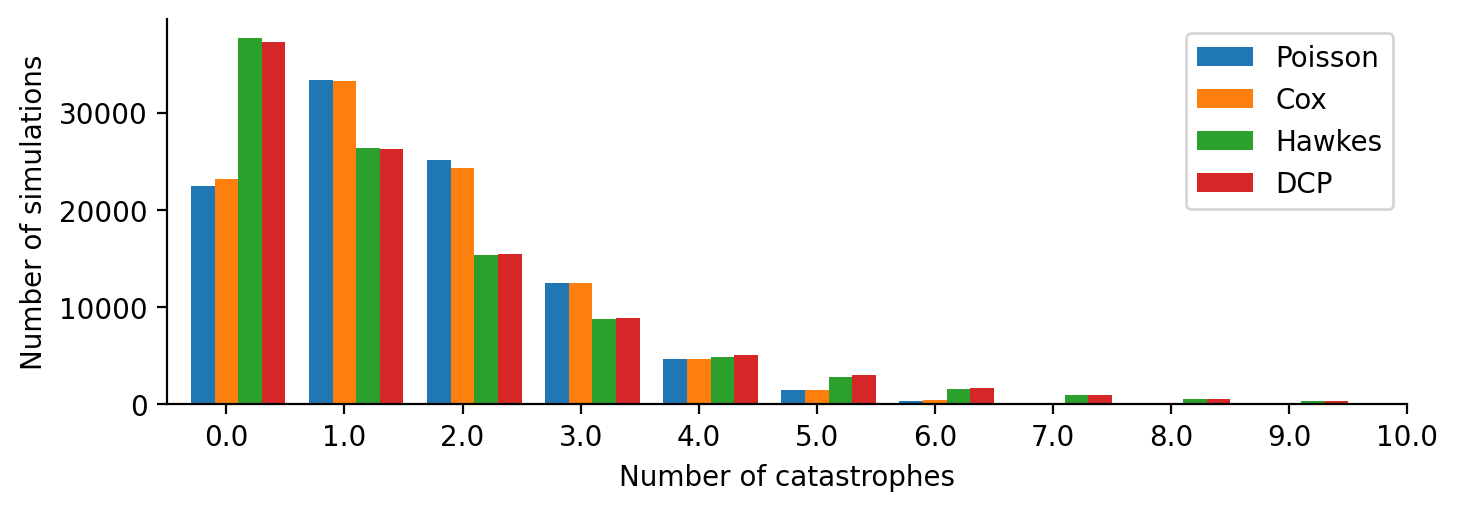

In [10]:
# Plot a grouped vertical bar charts showing the number of simulations which had `n` catastrophes according to each of the arrival processes.
def plot_num_cats(num_cats_poisson, num_cats_cox, num_cats_hawkes, num_cats_dcp):
    num_cats_poisson = np.floor(num_cats_poisson)
    num_cats_cox = np.floor(num_cats_cox)
    num_cats_hawkes = np.floor(num_cats_hawkes)
    num_cats_dcp = np.floor(num_cats_dcp)

    max_cats = np.max(
        [
            np.max(num_cats_poisson),
            np.max(num_cats_cox),
            np.max(num_cats_hawkes),
            np.max(num_cats_dcp),
        ]
    )
    min_cats = np.min(
        [
            np.min(num_cats_poisson),
            np.min(num_cats_cox),
            np.min(num_cats_hawkes),
            np.min(num_cats_dcp),
        ]
    )
    
    num_bins = int(max_cats - min_cats + 1)

    bins = np.linspace(min_cats, max_cats, num_bins + 1)
    bins = np.floor(bins)

    hist_poisson, _ = np.histogram(num_cats_poisson, bins=bins)
    hist_cox, _ = np.histogram(num_cats_cox, bins=bins)
    hist_hawkes, _ = np.histogram(num_cats_hawkes, bins=bins)
    hist_dcp, _ = np.histogram(num_cats_dcp, bins=bins)

    width = 0.2
    x = np.arange(len(bins) - 1)

    plt.bar(x - width, hist_poisson, width, label="Poisson")
    plt.bar(x, hist_cox, width, label="Cox")
    plt.bar(x + width, hist_hawkes, width, label="Hawkes")
    plt.bar(x + 2 * width, hist_dcp, width, label="DCP")

    plt.xticks(x, bins[:-1])
    plt.legend()

    plt.xlim(0.5, 11.0)
    plt.xlabel("Number of catastrophes")
    plt.ylabel("Number of simulations")

    # Change the aspect ratio to be wider
    plt.gcf().set_size_inches(8, 2.5)

    # Remove the top and right spines
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)


plot_num_cats(num_cats_poisson, num_cats_cox, num_cats_hawkes, num_cats_dcp)
plt.savefig("num_catastrophe_hists.png")

In [11]:
ROUNDING = 4

In [12]:
prices_poisson = calculate_prices(V_T, L_T, int_r_t, C_T_poisson, markup).round(ROUNDING)
display(prices_poisson)
print(prices_poisson.style.to_latex().replace("00 ", " ").replace("lrrrrrrr", "c|c|c|c|c|c|c|c"))

,$M=60$,$M=65$,$M=70$,$M=75$,$M=80$,$M=85$,$M=90$
$A=10$,7.2452,7.2523,7.2559,7.2577,7.2584,7.2588,7.2590
$A=15$,4.5729,4.5808,4.5847,4.5866,4.5874,4.5878,4.5880
$A=20$,2.7773,2.7859,2.7901,2.7922,2.7931,2.7935,2.7937
$A=25$,1.6323,1.6415,1.6461,1.6484,1.6494,1.6498,1.6500
$A=30$,0.9267,0.9367,0.9417,0.9441,0.9452,0.9456,0.9459


\begin{tabular}{c|c|c|c|c|c|c|c}
 & $M=60$ & $M=65$ & $M=70$ & $M=75$ & $M=80$ & $M=85$ & $M=90$ \\
$A=10$ & 7.2452 & 7.2523 & 7.2559 & 7.2577 & 7.2584 & 7.2588 & 7.2590 \\
$A=15$ & 4.5729 & 4.5808 & 4.5847 & 4.5866 & 4.5874 & 4.5878 & 4.5880 \\
$A=20$ & 2.7773 & 2.7859 & 2.7901 & 2.7922 & 2.7931 & 2.7935 & 2.7937 \\
$A=25$ & 1.6323 & 1.6415 & 1.6461 & 1.6484 & 1.6494 & 1.6498 & 1.6500 \\
$A=30$ & 0.9267 & 0.9367 & 0.9417 & 0.9441 & 0.9452 & 0.9456 & 0.9459 \\
\end{tabular}



In [13]:
prices_cox = calculate_prices(V_T, L_T, int_r_t, C_T_cox, markup).round(ROUNDING)
display(prices_cox)
print(prices_cox.style.to_latex().replace("00 ", " ").replace("lrrrrrrr", "c|c|c|c|c|c|c|c"))

,$M=60$,$M=65$,$M=70$,$M=75$,$M=80$,$M=85$,$M=90$
$A=10$,7.2439,7.2517,7.2557,7.2575,7.2583,7.2587,7.2589
$A=15$,4.5983,4.6068,4.6110,4.6130,4.6138,4.6142,4.6144
$A=20$,2.8218,2.8310,2.8355,2.8377,2.8386,2.8390,2.8392
$A=25$,1.6819,1.6919,1.6968,1.6991,1.7001,1.7006,1.7008
$A=30$,0.9747,0.9856,0.9910,0.9935,0.9945,0.9950,0.9953


\begin{tabular}{c|c|c|c|c|c|c|c}
 & $M=60$ & $M=65$ & $M=70$ & $M=75$ & $M=80$ & $M=85$ & $M=90$ \\
$A=10$ & 7.2439 & 7.2517 & 7.2557 & 7.2575 & 7.2583 & 7.2587 & 7.2589 \\
$A=15$ & 4.5983 & 4.6068 & 4.6110 & 4.6130 & 4.6138 & 4.6142 & 4.6144 \\
$A=20$ & 2.8218 & 2.8310 & 2.8355 & 2.8377 & 2.8386 & 2.8390 & 2.8392 \\
$A=25$ & 1.6819 & 1.6919 & 1.6968 & 1.6991 & 1.7001 & 1.7006 & 1.7008 \\
$A=30$ & 0.9747 & 0.9856 & 0.9910 & 0.9935 & 0.9945 & 0.9950 & 0.9953 \\
\end{tabular}



In [14]:
prices_hawkes = calculate_prices(V_T, L_T, int_r_t, C_T_hawkes, markup).round(ROUNDING)
display(prices_hawkes)
print(prices_hawkes.style.to_latex().replace("00 ", " ").replace("lrrrrrrr", "c|c|c|c|c|c|c|c"))

,$M=60$,$M=65$,$M=70$,$M=75$,$M=80$,$M=85$,$M=90$
$A=10$,8.0241,8.0950,8.1440,8.1786,8.2030,8.2201,8.2325
$A=15$,5.8437,5.9207,5.9736,6.0105,6.0365,6.0548,6.0678
$A=20$,4.2346,4.3185,4.3759,4.4157,4.4436,4.4630,4.4769
$A=25$,3.0401,3.1317,3.1941,3.2373,3.2673,3.2880,3.3028
$A=30$,2.1531,2.2522,2.3203,2.3672,2.3998,2.4221,2.4378


\begin{tabular}{c|c|c|c|c|c|c|c}
 & $M=60$ & $M=65$ & $M=70$ & $M=75$ & $M=80$ & $M=85$ & $M=90$ \\
$A=10$ & 8.0241 & 8.0950 & 8.1440 & 8.1786 & 8.2030 & 8.2201 & 8.2325 \\
$A=15$ & 5.8437 & 5.9207 & 5.9736 & 6.0105 & 6.0365 & 6.0548 & 6.0678 \\
$A=20$ & 4.2346 & 4.3185 & 4.3759 & 4.4157 & 4.4436 & 4.4630 & 4.4769 \\
$A=25$ & 3.0401 & 3.1317 & 3.1941 & 3.2373 & 3.2673 & 3.2880 & 3.3028 \\
$A=30$ & 2.1531 & 2.2522 & 2.3203 & 2.3672 & 2.3998 & 2.4221 & 2.4378 \\
\end{tabular}



In [15]:
prices_dcp = calculate_prices(V_T, L_T, int_r_t, C_T_dcp, markup).round(ROUNDING)
display(prices_dcp)
print(prices_dcp.style.to_latex().replace("00 ", " ").replace("lrrrrrrr", "c|c|c|c|c|c|c|c"))

,$M=60$,$M=65$,$M=70$,$M=75$,$M=80$,$M=85$,$M=90$
$A=10$,8.1990,8.2700,8.3193,8.3543,8.3797,8.3974,8.4102
$A=15$,5.9867,6.0640,6.1171,6.1545,6.1816,6.2005,6.2139
$A=20$,4.3423,4.4267,4.4844,4.5247,4.5536,4.5737,4.5880
$A=25$,3.1202,3.2123,3.2752,3.3191,3.3503,3.3718,3.3870
$A=30$,2.2087,2.3081,2.3767,2.4244,2.4585,2.4817,2.4979


\begin{tabular}{c|c|c|c|c|c|c|c}
 & $M=60$ & $M=65$ & $M=70$ & $M=75$ & $M=80$ & $M=85$ & $M=90$ \\
$A=10$ & 8.1990 & 8.2700 & 8.3193 & 8.3543 & 8.3797 & 8.3974 & 8.4102 \\
$A=15$ & 5.9867 & 6.0640 & 6.1171 & 6.1545 & 6.1816 & 6.2005 & 6.2139 \\
$A=20$ & 4.3423 & 4.4267 & 4.4844 & 4.5247 & 4.5536 & 4.5737 & 4.5880 \\
$A=25$ & 3.1202 & 3.2123 & 3.2752 & 3.3191 & 3.3503 & 3.3718 & 3.3870 \\
$A=30$ & 2.2087 & 2.3081 & 2.3767 & 2.4244 & 2.4585 & 2.4817 & 2.4979 \\
\end{tabular}

